In [ ]:
using ProgressBars;
using ProgressMeter
using LinearAlgebra, Plots, FFTW;
using LoggingExtras, ProgressLogging, Logging, TerminalLoggers

import LinearSolve as LS
using SparseArrays
using QuadGK;
using SpecialFunctions: gamma, loggamma, zeta

# Functions

function central_diff_vec(vec, h)
    vec_ip1 = circshift(vec,-1)
    vec_im1 = circshift(vec,1)
    return (vec_ip1-vec_im1)/(2*h)
end


function m_T_func(x)
    m_T_func_unnorm = (x) -> exp(-(x-0.5)^2/0.1^2)
    oneOverC, error = quadgk(m_T_func_unnorm, 0, 1); #Why 0, 1? Double check
    return (1/oneOverC) * m_T_func_unnorm(x) 
end

function Gh_func(M)
    return zeros(length(M))
end

function conv_fft(M, x_grid, h, δ) # Double check
    N = length(M)
    L = x_grid[end] - x_grid[1]   # domain length

    # grid differences, wrapped into (-L/2, L/2]
    raw_diffs = collect(0:N-1) .* h
    diffs = raw_diffs .- round.(raw_diffs ./ L) .* L

    # Gaussian kernel on differences
    ϕ = exp.(-(diffs.^2) ./ (2δ^2))
    ϕ ./= (h * sum(ϕ))   # normalization

    # FFT-based circular convolution
    conv = real(ifft(fft(ϕ) .* fft(M)))
    return conv
end


function Fh_func(M_n, t_n, δ, x_grid, h)
    #ϕ_δ=1/(δ* sqrt(2*π)) * exp.(- (x_grid .^ 2) / (2*δ^2))
    conv_term = conv_fft(M_n, x_grid, h, δ) 
    return 5* ((M_n .- 0.5*(sin(2*π*t_n))) .^ 2)+ conv_term #Double check
end

function H_func(p)
    return p^2 / 2
end

function create_mathcalF(x, U_n, PDL_matrix, M_n, Δt, n, h, ν, x_grid) 
    F_hM_n = Fh_func(M_n, (n-1)*Δt, δ, x_grid, h)
    δ_hx = central_diff_vec(x, h)
    Hδ_hx= (1/2)*H_func.(δ_hx)
    return x-U_n+Δt*(ν*PDL_matrix*x+ Hδ_hx-F_hM_n)
end

##########################

# Matrices 

function create_Jacobian(N_h, U, PDL_matrix, Δt, h, ν) # When Hamiltonian H = p^2 / 2
    
    δ_hU = central_diff_vec(U,h)

    subdiag = -1*circshift(δ_hU,-1)[1:N_h-1]
    supdiag = δ_hU[1:N_h-1]

    deriv_Ham_δ_hU_mat = zeros(N_h, N_h)+ Tridiagonal(subdiag,zeros(N_h),supdiag) 
    deriv_Ham_δ_hU_mat[1,end] = -1*δ_hU[1]
    deriv_Ham_δ_hU_mat[end, 1] = δ_hU[end]

    J_F = I + Δt*(ν*PDL_matrix+ (1/(2h))*deriv_Ham_δ_hU_mat)
    return J_F
end 


function create_PDL_matrix(N_h, α, h, R) # new method, spectral method. Verified agains old method, and gives zero row sums.
    k = collect(0:N_h-1)
    λ = (2 .- 2 .* cos.(2π .* k ./ N_h)).^(α/2) ./ h^α  # λ_0 = 0
    # First column of the circulant is the inverse FFT of eigenvalues
    c = real(ifft(λ))                       # first column
    D = zeros(Float64, N_h, N_h)
    for j in 1:N_h
        D[:, j] = circshift(c, j-1)
    end
    return D
end

#######################

# HJB algorithm

function new_HJB_step(num_iter_HJB, N_h, U_n, M_n, PDL_matrix, Δt, h, ν, n, x_grid)
    x_k = U_n

    
    #println("Starting Netwon's method...")
    @showprogress 1 "Newtons (HJB) iterations" for k in 1:num_iter_HJB
        #println("k=",k)
        J_F = create_Jacobian(N_h, x_k, PDL_matrix, Δt, h, ν)
        mathcalFx_k = create_mathcalF(x_k, U_n, PDL_matrix, M_n, Δt, n, h, ν, x_grid)
        δ_k =  J_F \ mathcalFx_k
        x_kp1 = x_k - δ_k
        x_k = x_kp1
    end
    U_np1 = x_k
    return U_np1
end

function new_HJB_solve(N_h, N_T, M_mat, PDL_matrix, Δt, h, ν, num_iter_HJB, x_grid)
    U_mat = Array{Float64}(undef, N_h, N_T)
    U_mat[:,1] = Gh_func(M_mat[:,1])

    #println("Starting HJB_solve ...")
    @showprogress 1 "HJB iterations" for n in 1:(N_T-1) 
        #println("n=",n)
        U_mat[:, n+1] = new_HJB_step(num_iter_HJB, N_h, U_mat[:,n], M_mat[:,n], PDL_matrix, Δt, h, ν, n, x_grid)
    end
    return U_mat
end

##########################

# FPK algorithm

function new_FPK_step(N_h, M_np1, U_np1, PDL_matrix, h, ν, Δt)
    T = zeros(N_h, N_h)
    U_diff_vec = central_diff_vec(U_np1, h)
    T += Tridiagonal(-1*U_diff_vec[1:(N_h-1)], zeros(N_h), circshift(U_diff_vec, -1)[2:N_h]) 
    T[1,end] = -U_diff_vec[end]
    T[end,1] = U_diff_vec[1]
    
    M_n = (I+Δt*(ν*PDL_matrix-(1/(2h))*T)) \ M_np1

    return M_n
end

function new_FPK_solve(U_mat, M_T, PDL_matrix, N_h, Δt, N_T, h, ν, α)
    M_mat = Array{Float64}(undef, N_h, N_T)
    M_mat[:,end] = M_T

    @showprogress 1 "FPK iterations" for j in 1:(N_T-1)
        M_mat[:,N_T-j] = new_FPK_step(N_h, M_mat[:, N_T-j+1], U_mat[:, N_T-j+1], PDL_matrix, h, ν, Δt)
    end
    return M_mat
end

###############################

# MFG algorithm

function MFG_solve(N_h, N_T, h, Δt, num_it_MFG, num_it_HJB, M_T, α, δ, R, x_grid)
    M_mat = repeat(M_T, 1, N_T)
    U_mat = Array{Float64}(undef, N_h, N_T);
    PDL_matrix = create_PDL_matrix(N_h, α, h, R)

    println("Starting MFG_solve for loop...")

    #logger = TeeLogger(ConsoleLogger(), LoggingExtras.SimpleLogger(stdout))
    #global_logger(logger)

    @showprogress 1 "MFG iterations" for j in 1:num_it_MFG
        println("MFG iterations. j=",j, "/", num_it_MFG)
        U_mat = new_HJB_solve(N_h, N_T, M_mat, PDL_matrix, Δt, h, ν, num_it_HJB, x_grid)
        M_mat = new_FPK_solve(U_mat, M_T, PDL_matrix, N_h, Δt, N_T, h, ν, α)
    end
    return (U_mat, M_mat)
end


MFG_solve (generic function with 1 method)

In [4]:
println("HI")

HI


In [ ]:
# Run SIMULATION

using DelimitedFiles;
using Glob
using JSON

println("RUN SIMULATION")
####Choose grid sizes and parameters:
h_reference = 1/2^9
h_list = [1/2^6, 1/2^7,1/2^8, h_reference]

α = 1.5
x_l = -1
x_r = 2
Δt = 0.01
t_0 = 0
T = 1
ν=0.09^2
num_it_MFG=50
num_it_HJB=20
δ = 0.4
R=30

###################################+

#### For saving runs ####
runs_folder = "notebooks/new_MFG_convergence_rate_runs/" #Folder to save runs too. NB: Change run number so old runs aren't overwritten.
isdir(runs_folder) || mkpath(runs_folder)

run_files = readdir(runs_folder)
# Extract run numbers
run_numbers = Int[]
for f in run_files
    if occursin(r"^run\d+_", f)  # filenames like "run7_U_mat_..."
        m = match(r"^run(\d+)_", f)
        if m !== nothing
            push!(run_numbers, parse(Int, m.captures[1]))
        end
    end
end

run_number = isempty(run_numbers) ? 1 : maximum(run_numbers) + 1
println("New run_number = $run_number")
##########

params = Dict(
    "h_list" => Float64[],
    "α" => α,
    "x_l" => x_l,
    "x_r" => x_r,
    "Δt" => Δt,
    "t_0" => t_0,
    "T" => T,
    "ν" => ν,
    "num_it_MFG" => num_it_MFG,
    "num_it_HJB" => num_it_HJB,
    "δ" => δ,
    "R" => R,
)

params_file = joinpath(runs_folder, "run$(run_number)_params.json")
###################################


M_list = Array{Float64}[]
U_list = Array{Float64}[]


for h in h_list
    println("")
    println("start for loop, h=", h)
    println("Running MFG_solve with h=", h)

    x_grid = x_l:h:(x_r-h)
    t_vec = t_0:Δt:(T-Δt)
    N_h =length(x_grid)
    N_T =length(t_vec)
    M_T =  m_T_func.(x_grid);
    
    (U_mat, M_mat) = MFG_solve(N_h, N_T, h, Δt, num_it_MFG, num_it_HJB, M_T, α, δ, R, x_grid);
    
    M_mat = reverse(M_mat, dims=2);
    U_mat = reverse(U_mat, dims=2);
    println("Done running MFG_sovle with h=", h)
 
    println("size(M_mat): ", size(M_mat))
    println("size(U_mat): ", size(U_mat))

    push!(M_list, M_mat)
    push!(U_list, U_mat)
    
    println("Writing results to file...")
    writedlm(joinpath(runs_folder, "run$(run_number)_U_mat_conv_h$(h)_deltat$(Δt).csv"), U_mat, ",")
    writedlm(joinpath(runs_folder, "run$(run_number)_M_mat_conv_h$(h)_deltat$(Δt).csv"), M_mat, ",")

    # Add completed h to params and save again
    push!(params["h_list"], h)
    open(params_file, "w") do io
        JSON.print(io, params; indent = 4)
    end
end

RUN SIMULATION
New run_number = 1

start for loop, h=0.015625
Running MFG_solve with h=0.015625
Starting MFG_solve for loop...
MFG iterations. j=1/50

HJB iterations   9%|████                                 |  ETA: 0:00:10

HJB iterations 100%|█████████████████████████████████████| Time: 0:00:08


MFG iterations. j=2/50


HJB iterations 100%|█████████████████████████████████████| Time: 0:00:07
MFG iterations   4%|██                                   |  ETA: 0:06:48

MFG iterations. j=3/

HJB iterations  14%|██████                               |  ETA: 0:00:06

50


HJB iterations 100%|█████████████████████████████████████| Time: 0:00:07
MFG iterations   6%|███                                  |  ETA: 0:06:28

MFG iterations. j=4/50

HJB iterations  14%|██████                               |  ETA: 0:00:06

HJB iterations 100%|█████████████████████████████████████| Time: 0:00:07
MFG iterations   8%|███                                  |  ETA: 0:06:15

MFG iterations. j=5/50

HJB iterations  14%|██████                               |  ETA: 0:00:06

HJB iterations 100%|█████████████████████████████████████| Time: 0:00:07
MFG iterations  10%|████                                 |  ETA: 0:06:02

MFG iterations. j=6/50

In [ ]:
#PDL testing. NB: Artifacts at boundary!

# x = range(-1000, 1000, length = 10000)
# println("HI")
# h = x[2] - x[1]
# α = 1.5
# u = (x) -> (1+x^2)^(-(1-α)/2)
# fracLap_u = (x) -> 2^α * gamma((1+α)/2)/gamma((1-α)/2) * (1+x^2)^(-(1+α)/2)
# p2 = plot(x, fracLap_u.(x), xlim=(-10,10), label="fracLap_u")

# PDL = fft_create_PDL_matrix(10000, α, h, 100) 
# PDL_u = PDL*u.(x)

# scatter!(p2, x, PDL_u, xlim=(-10,10), label="PDL_u")

In [6]:
using DelimitedFiles;
using JSON
using DelimitedFiles;
using Plots, LaTeXStrings;
using Printf


function read_run_results(run_number)
    U_list = []
    M_list = []
    run="new_MFG_convergence_rate_runs/run"*string(run_number)
    params = JSON.parsefile(run*"_params.json")
    Δt = params["Δt"]
    for h in params["h_list"]
        push!(U_list, readdlm(run*"_U_mat_conv_h$(h)_deltat$(Δt).csv", ','))
        push!(M_list, readdlm(run*"_M_mat_conv_h$(h)_deltat$(Δt).csv", ','))
    end
    return params, U_list, M_list
end

params, U_list, M_list = read_run_results(1)
println("params: ", params)
println("size(U_list[1]): ", size(U_list[1]))

#PLOT RESULTS

function plot_results(run_number, save_figures=false)
    params, U_list, M_list = read_run_results(run_number)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    println("Plot results for run number: ", run_number) 
    println("!!")
    println("parameters: ", params)
    println("size(U_list): ", size(U_list))
    flush(stdout)
    for (i,h) in enumerate(h_list)
        println("----")
        println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        println("x_vec: ", x_vec)
        println("N_h: ", N_h)
        println("t_vec: ", t_vec)
        println("N_T: ", N_T)

        plot_U_mat = U_list[i];
        plot_M_mat = M_list[i];

        zticks1 = 5:5:20
        p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
        color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,t_vec[end]), ylim=(0.1,0.9), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
        zticks2 = 0.5:0.5:4
        p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
        color=:cividis, size=(500, 500), xlim=(0,t_vec[end]), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)",  ylim=(0, 1))

        # Save plots as PDF with h in the filename
        if save_figures
            savefig(p1, joinpath("figures",run*"_plot_new_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p2, joinpath("figures",run*"_plot_new_U_h$(h)_deltat$(Δt).pdf"))
        end 
        p = plot(p1, p2, layout=2, size=(600, 300), title="h="*string(h), titlefontsize=10)
        println("Display:") 
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

params: Dict{String, Any}("T" => 1, "δ" => 0.4, "x_l" => -1, "h_list" => Any[0.015625, 0.0078125], "x_r" => 2, "ν" => 0.0081, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.01, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list[1]): (192, 100)


plot_results (generic function with 2 methods)

Plot results for run number: 1
!!
parameters: Dict{String, Any}("T" => 1, "δ" => 0.4, "x_l" => -1, "h_list" => Any[0.015625, 0.0078125], "x_r" => 2, "ν" => 0.0081, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.01, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list): (2,)
----
i: 1
x_vec: -1.0:0.015625:1.984375
N_h: 192
t_vec: 0.0:0.01:0.99
N_T: 100
Display:
!!!!!!!!!
----
i: 2
x_vec: -1.0:0.0078125:1.9921875
N_h: 384
t_vec: 0.0:0.01:0.99
N_T: 100
Display:
!!!!!!!!!


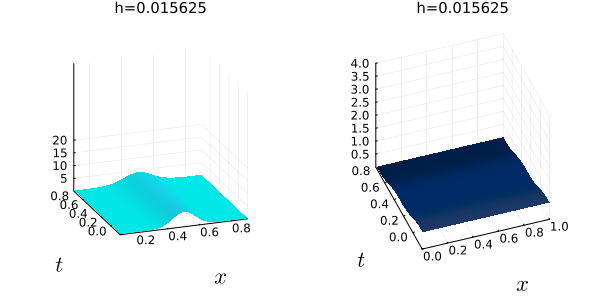

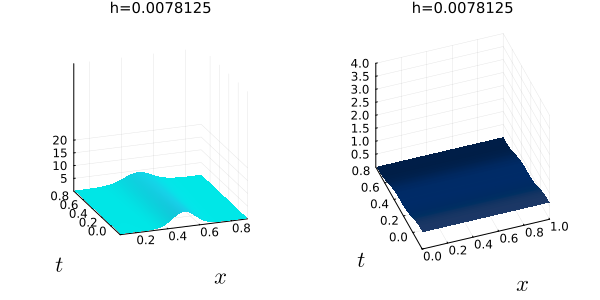

In [7]:
plot_results(1)

In [21]:

#PLOT RESULTS AT FINAL TIME

function plot_final_time_results(run_number, save_figures=false)
    params, U_list, M_list = read_run_results(run_number)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    println("FINAL TIME PLOTS")
    println("Plot results for run number: ", run_number) 
    println("!!")
    println("parameters: ", params)
    println("size(U_list): ", size(U_list))
    flush(stdout)
    for (i,h) in enumerate(h_list)
        println("----")
        println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        println("x_vec: ", x_vec)
        println("N_h: ", N_h)
        println("t_vec: ", t_vec)
        println("N_T: ", N_T)

        ###################################
        time_index = div(length(t_vec),1)
        println("time_index: ", time_index)

        plot_U_mat_final = U_list[i][:,1];
        plot_M_mat_final = M_list[i][:,time_index];
        plot_U_mat_first = U_list[i][:,time_index];
        plot_M_mat_first = M_list[i][:,1];

        p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[time_index]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[1]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        p3 = plot(x_vec, plot_M_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[1]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        
        p4 = plot(x_vec, plot_U_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[time_index]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        if save_figures
            savefig(p1, joinpath("figures",run*"_final_time_plot_final_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p2, joinpath("figures",run*"_final_time_plot_final_U_h$(h)_deltat$(Δt).pdf"))
            savefig(p3, joinpath("figures",run*"_final_time_plot_first_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p4, joinpath("figures",run*"_final_time_plot_first_U_h$(h)_deltat$(Δt).pdf"))
        end
        p = plot(p1, p2, p3, p4, layout=4, size=(600, 600), titlefontsize=10)
        println("Display:")
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

plot_final_time_results (generic function with 2 methods)

FINAL TIME PLOTS
Plot results for run number: 1
!!
parameters: Dict{String, Any}("T" => 1, "δ" => 0.4, "x_l" => -1, "h_list" => Any[0.015625, 0.0078125], "x_r" => 2, "ν" => 0.0081, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.01, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list): (2,)
----
i: 1
x_vec: -1.0:0.015625:1.984375
N_h: 192
t_vec: 0.0:0.01:0.99
N_T: 100
time_index: 100
Display:
!!!!!!!!!
----
i: 2
x_vec: -1.0:0.0078125:1.9921875
N_h: 384
t_vec: 0.0:0.01:0.99
N_T: 100
time_index: 100
Display:
!!!!!!!!!


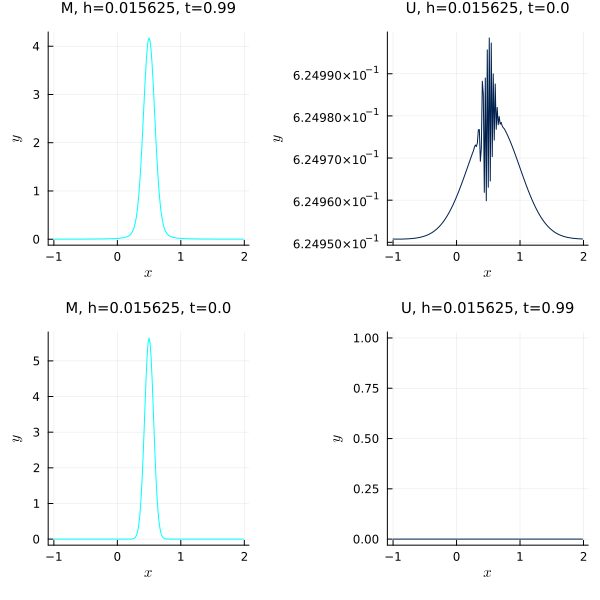

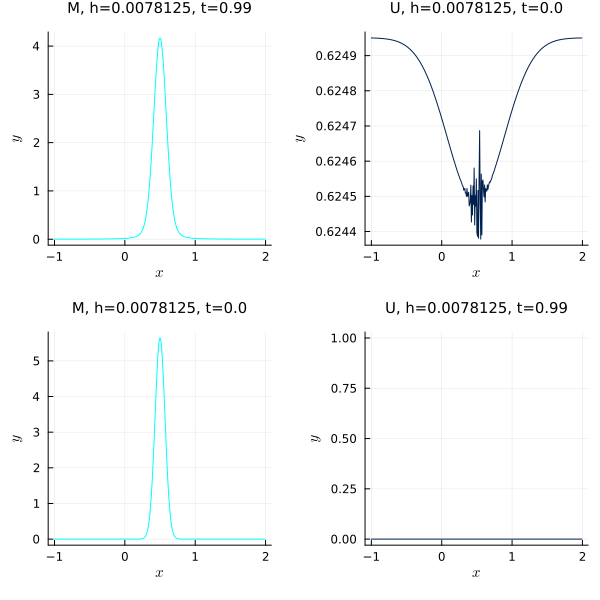

In [22]:
plot_final_time_results(1)